In [1]:
import os
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn

from random import randint
np.random.seed(2023)

/home/vateseifelfrej/anaconda3/envs/maddpg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_goal_id = 3         # dimension of goal id (color of other agent landmark)
n_tokens = 10         # number of language tokes
n_landmarks = 3       # number of landmarks
batch_size = 128      # batch size
n_episodes = 20000    # number of training episodes

In [8]:
def num2token(num: int) -> chr:
  return chr(ord('A')+num)


class MLPNetwork(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=64, non_linear=nn.ReLU()):
        super(MLPNetwork, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            non_linear,
            nn.Linear(hidden_dim, hidden_dim),
            non_linear,
            nn.Linear(hidden_dim, out_dim),
        ).apply(self.init)

    @staticmethod
    def init(m):
        """init parameter of the module"""
        gain = nn.init.calculate_gain('relu')
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight, gain=gain)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        return self.net(x)

In [4]:
# landmark colors
landmarks_c = [[0.75, 0.25, 0.25], [0.25, 0.75, 0.25], [0.25, 0.25, 0.75]]
landmarks_c = [torch.tensor(l).unsqueeze(0) for l in landmarks_c]

# init agents
speaker = MLPNetwork(3, n_tokens)
listener = MLPNetwork(2 + 2*n_landmarks + n_goal_id + n_tokens, 2)
params = list(speaker.parameters()) + list(listener.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)

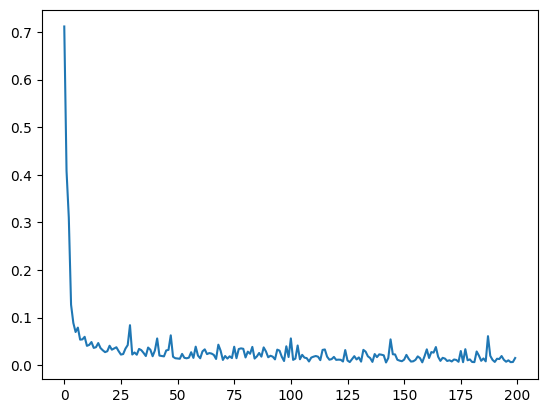

In [5]:
loss_history = []

for i in range(n_episodes):
  # relative position of landmarks wrt to listener
  landmarks_p = (torch.rand((batch_size, 2*n_landmarks)) - 0.5) * 2
  # velocity of listener
  vel = torch.rand((batch_size, 2))
  # sample target landmark
  ix = randint(0, n_landmarks-1)
  # pass through observer
  msg = F.gumbel_softmax(speaker(landmarks_c[ix].repeat(batch_size, 1)), hard=True)
  # goal id (kinda useless to have it)
  goal_id = torch.cat(list(landmarks_c[randint(0, n_landmarks-1)] for _ in range(batch_size)), 0)
  # listener obesrvation
  obs = torch.cat((vel, landmarks_p, goal_id, msg), 1)
  # predict landmark pos
  pred = listener(obs)
  # backprop
  optimizer.zero_grad()
  target = landmarks_p[:,ix*2:(ix+1)*2]
  lossfun = nn.L1Loss()
  loss = lossfun(pred, target)
  loss.backward()
  optimizer.step()

  if i%100==0:
    loss_history.append(loss.item())

plt.plot(loss_history)

In [12]:
# relative position of landmarks wrt to listener
landmarks_p = [(torch.rand((1, 2)) - 0.5) * 2 for _ in range(n_landmarks)]
# velocity of listener
vel = torch.rand((1, 2))
# sample target landmark
ix = randint(0, n_landmarks-1)
# pass through observer
msg = F.gumbel_softmax(speaker(landmarks_c[ix]), hard=True)
print(f"Observer output: {msg}")
print(f"msg: {num2token(msg.unsqueeze(0).argmax().item())}")
# goal id (kinda useless to have it)
goal_id = landmarks_c[randint(0, n_landmarks-1)]
# listener obesrvation
obs = torch.cat((vel, *landmarks_p, goal_id, msg), 1)
# predict landmark pos
pred = listener(obs)
print(ix)
print(landmarks_p[ix])
print(pred)

Observer output: tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<AddBackward0>)
msg: C
1
tensor([[0.9393, 0.0443]])
tensor([[0.9341, 0.0406]], grad_fn=<AddmmBackward0>)


In [7]:
# create folder to save result
env_dir = os.path.join(os.path.abspath('../'), 'results/', 'simple_reference_v2')
if not os.path.exists(env_dir):
  os.makedirs(env_dir)
total_files = len([file for file in os.listdir(env_dir)])
result_dir = os.path.join(env_dir, f'{total_files + 1}')
os.makedirs(result_dir)

# dict with models
models = {'speaker': speaker, 'listener': listener}

# store models
torch.save(
    {name: model.state_dict() for name, model in models.items()},  # actor parameter
    os.path.join(result_dir, 'model.pt')
)